<h1> Trends in Technological Advancements </h1>

Academic papers, patents and trademarks are often a very good indication of the direction in which a field of research is evolving. In this project, we aim to procure and analyze millions of patents, published academic work and trademarks. The procured documents must range over a wide period of time (30+ years) and over diverse fields in order give us a sense of how academic research has evolved over time and how inter and cross disciplinary research has grown.

**Dataset:**
- The US Patent and Trademark Office has made all its patent and trademark information freely available for public use. The database consists of 9.4 million records from 1981 to present.
- Utilizing public databases of published academic work (such as Google Scholar) to obtain relevant material.

**Project Objectives:**
- Identify key trends in the development of specific fields of research (eg. Advances in Deep Learning).
- Geographical analysis of research output and understanding why different parts of the world are focussed on different fields.
- Performing a time analysis on the data to determine the “right time” to publish (great work published too early or too late into the growth of a field are not taken well).

In [5]:
%matplotlib inline
import scipy.sparse as sp
import numpy as np 
import sklearn.preprocessing as sk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import collections
stop_list=stopwords.words('english')
from tfidf_and_cosine import tfidf
from tfidf_and_cosine import cosine_similarity
import operator
import pickle


<h2>Data Collection</h2>

### Google Scholar

Google scholar is a publicly available and freely accesible search engine for scholarly literature. Here we try to obtain publication data from Google Scholar by developing a querier and parser for Google Scholar output. Although there are open source parsers [[1]](https://github.com/ckreibich/scholar.py) that do this, it is easier to write a customized parser that parses the information we need. It's classes can be invoked independently or used as a command line tool. Currently the parser implements the full functionality of Scholar's *Advanced Search* option and recursively retrieves the titles of the search outputs. Since Google does not provide the complete abstract in its output, there is no way simple way to parse the complete abstract for all results. The following code run from the command line parses the first 1000 results for a particular query and dumps them into a .pkl file.

In [ ]:
!./scholared.py -A "deep learning" --after 2005 --before 2010

The above line of code executed by the shell, parses all results for the search phrase "deep learning" published between the dates 2005 and 2010 and dumps them into a pkl file. This allows us to use this data later for further analysis.

<h3>From USPTO Bulk data</h3>

The US Patent and Trademark Office has made all its patent and trademark information freely available for public use. This data can be found <a href='https://pairbulkdata.uspto.gov/'>here</a>. The database consists of 9.4 million records from 1981 to present. This data is available in XML and JSON formats out of which, we chose to work with data in JSON format owing to ease of working with JSON structures. Currently, we are extracting the titles of each of the patent out of the year wise bulk data of patents. Following code extracts titles of patents from json data of patents information.

In [1]:
from DataCollection import dataCollection

# Extract titles of all patents of the 2016 year
# Takes 2016.json and dumps into 2016.pkl
dataCollection(2016)

ImportError: No module named DataCollection

<h3> TFIDF MATRIX </h3>

Once,the Titles Have been collected,we aim to make some sense of it.We import the Data from the Pickle File which is stored in our Local Directory.We import the NLTK Stop Work List and remove Blank Spaces as well from each of The Titles.After this,it is fed into our TFIDF Matrix which resturns the Sparse Matrix,Dictionary of Word Count,and the List of Unique words which are present in all of the Patent Titles.

In [ ]:
testp = pickle.load( open( "2016.pkl", "rb" ) )
#print len(testp)
number_of_docs=5000
x=testp[1:number_of_docs]

x=[xx.encode('UTF8') for xx in x]
#####STOP WORD REMOVAL START########################
test_1=[]
for sentence in x:
    sentence=sentence.lower()
    text = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
    test_1.append(text)
    
#print test_1
##############STOP WORD REMOVAL COMPLETE############################
sparse_mat,word_list,dict_words=tfidf(x)
            
print sparse_mat.todense()
print word_list
print dict_words

 



Here,we have printed the Given Sparse Matrix,List of Unique Words and The Dicitonary Entries correspondeding to each UNique Word and its count in all of the Documents.

<h3> Analysis on Data </h3>

[('AMINO-ALCOHOL', 8281), ('Situ', 8280), ('Bacteria', 8279), ('Site', 8278), ('SELF', 8277), ('INCREASED', 8276), ('Surface-modified', 8275), ('OXAZOLE', 8274), ('LOCAL', 8273), ('VALUABLE', 8272), ('INSECT', 8271), ('GEARED', 8270), ('SPACE', 8269), ('BALLS', 8268), ('Procedures', 8267)]
Document which is Most Similar to all is SYSTEM AND METHOD FOR LASER LYSIS


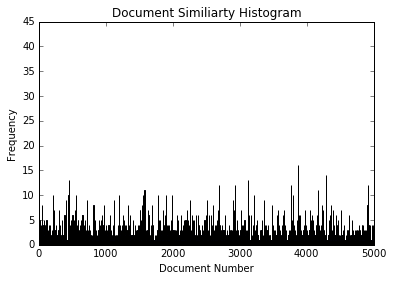

In [16]:
thres=15
#print dict_words
#top=sorted(dict_words, key=c.__getitem__)
top = sorted(dict_words.items(), key=operator.itemgetter(1))
#print top
top_n=top[len(top)-thres:]
top_n=top_n[::-1]
print top_n 

###########GETTING MOST SIMILAR DOCUMENTS############
doc_sim=cosine_similarity(sparse_mat)  
#print doc_sim
M,N=(doc_sim).shape
#print M,N
a = np.ones((M, M), int)
np.fill_diagonal(a, 0)
#print a
Cosine_List=np.multiply(doc_sim,a)
#print Cosine_List
Highest_Sim=np.argmax(Cosine_List,axis=1)
High=np.argmax(Highest_Sim)
#print High
print "Document which is Most Similar to all is:",testp[High]
plt.hist(Highest_Sim,M)
plt.title("Document Similiarty Histogram")
plt.xlabel("Document Number")
plt.ylabel("Frequency")

###############PLOTTING THEM#####################



We attempt to Clean the Derive Similiarties Among Documents using the Cosine Similiairty Function,and see which documents  are the most co-rellated with each other.By setting the Diagonal Eleemnts to Zero,can easily extract the individual document which is most similar to the current one.We proceed to list all of these docuemnts and the Histogram is plotted above .For our given analysis,based on Document Title,the most similar one is "System and Method for Laser Lysis"